## Generación de ejemplos adversarios - Algoritmo FGSM
### Alumnos: Benjamín Castro y Jordan Pérez
### Ayudante: Andrés González
### Profesor: Pablo Estévez
### **EL 4106-1** Inteligencia computacional

In [2]:
# Imports de librerías
import torch 
from torch import nn
import torchvision
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import time

In [9]:
# Descargar desde la url el dataset de MNIST
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

#### Importación de base de datos MNIST y modelo pre entrenado

In [3]:
# Dataset MNIST
mnist_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

mnist_dataset = torchvision.datasets.MNIST(
    root="./mnist",
    train=True,
    download=True,
    transform=mnist_transform,
)
# Modelo pre-entrenado (pesos se cargan en carpeta data)
pretrained_model = "data/lenet_mnist_model.pth"

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [4]:
# Carga del conjunto de prueba
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../data', train=False, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



#### Red neuronal convolucional

In [7]:
class Net(nn.Module): # Red neuronal convolucional de LeNet [1]
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
# En este caso no se usa GPU
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [11]:
# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

#### Algoritmo FGSM

In [12]:
def fgsm_attack(img,epsilon,data_grad): # [1]
  # Se encarga de obtener el signo del gradiente de la data para añadir ruido en la dirección correspondiente
  sign_data_grad = data_grad.sign()
  # Añade el ruido a la imagen
  perturbed_image = img + epsilon*sign_data_grad
  # Mantiene la perturbación en el rango entre 0 y 1
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  return perturbed_image

In [17]:
def test( model, device, test_loader, epsilon ): # [1]

    # Contador de aciertos
    correct = 0
    adv_examples = []

    # Iterar en el conjunto de prueba
    for data, target in test_loader:

        # Enviar la data al computador para procesamiento
        data, target = data.to(device), target.to(device)

        # Requiere gradiente de la data
        data.requires_grad = True

        # Pasa los datos por el modelo
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # Se obtiene la predicción con mayor probabilidad

        # Continuar atacando
        if init_pred.item() != target.item():
            continue

        # Cálculo de pérdidas
        loss = F.nll_loss(output, target)

        # Inicializa en cero los gradientes
        model.zero_grad()

        # Realiza el backpropagation 
        loss.backward()

        data_grad = data.grad.data

        # Imágenes perturbadas son generadas por función de ataque
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Pasar la data perturbada al modelo
        output = model(perturbed_data)

        # Casos de éxito
        final_pred = output.max(1, keepdim=True)[1] # Predicción con mayor probabilidad 
        if final_pred.item() == target.item():
            correct += 1
            # Imágenes sin perturbación
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Ejemplos adversarios para mostrar
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calcula accuracy final en el conjunto de prueba
    final_acc = correct/float(len(test_loader))
    # Accuracy v/s tamaño de perturbación
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [14]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


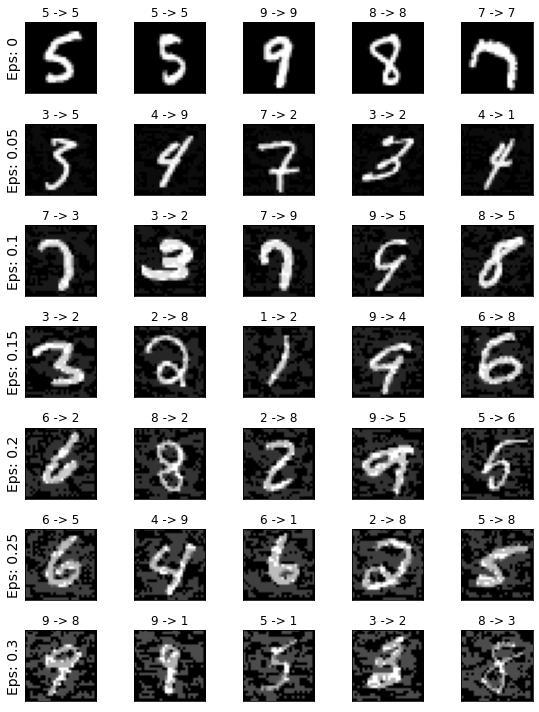

In [18]:
# Ejemplos adversarios para mostrar
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### Referencias
#### [1] Pytorch *FGSM Tutorial*. Documentación de ejemplo para ataque tipo FGSM. Disponible en: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html. Consultado el día 13 de octubre de 2022